In [1]:
import Pkg; Pkg.add(["Plots","Interact","StatsPlots"]);
import Logging; Logging.disable_logging(Logging.Info)

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


LogLevel(1)

In [2]:
const STATIC_LECTURE = true;

In [3]:
using LinearAlgebra;
using Plots; gr(); default(l=5, size=(900,550), label=false);
using Printf;
using Interact;
using SparseArrays;
using StatsPlots;

BLAS.set_num_threads(1)

if STATIC_LECTURE
    default(fmt=:png)
    macro manipulate(v)
        return :($v; plot!())
    end
end

prettyprint(a) = map(x -> @sprintf("%+.2f", x), a)
sciprint(a) = map(x -> @sprintf("%+.2e", x), a)

function imshow(x; kwargs...)
    return heatmap(x
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=cgrad(:diverging_gwv_55_95_c39_n256, rev=true)
        ; kwargs...
    )
end
function imshowlog(x; kwargs...)
    return heatmap(max.(log.(abs.(x)), log(eps()))
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=cgrad(:linear_worb_100_25_c53_n256)
        ; kwargs...
    )
end
bigspy(x; kwargs...) = spy(x, m=4, c=:diverging_gwv_55_95_c39_n256; kwargs...)
p = plot!([0,1],[0,1]);

WebIO._IJuliaInit()

# Preconditioned Krylov Subspace Methods for Sampling Multivariate Gaussian Distributions

## Multivariate Gaussian distributions

### What are matrices for? (What do we do with them?)

If you were making a `Matrix` class, what interface methods would you include?

1. **Meaning in and of themselves**

- Example: a data frame
- What we do: access individual entries $(i,j) \mapsto a_{ij}$

2. **Linear operators**

- Examples: the Laplacian; a regression model
- What we do:

  a. Matrix-vector product: $x \mapsto A x$
  
  b. Matrix-inverse product: $x \mapsto A^{-1} x$
  
  c. Matrix pseudo-inverse product: $x \mapsto A^{+} x$

3. **Elements in an algebra**

- Example: computational geometry
- What we do: matrix-matrix product $(A, B) \mapsto AB$

4. (hpd) **Inner product definitions**

- Example: system energy in physics / chemistry

- What we do: compute norm $x \mapsto \sqrt{x^* A x}$

### An important thing symmetric semipositive definite matrices are for: covariance matrices

**Recall** the univariate **normal** / **Gaussian** distribution

A probability distribution $\mathcal{N}(\mu,\sigma^2)$ with two free parameters: the **mean** $\mu$ and **standard deviation** $\sigma$

The most important distribution in statistics:

If you draw **independent samples** from any (reasonable) distribution enough, the distribution of the sample mean starts to resemble a Gaussian distribution (central limit theorem)

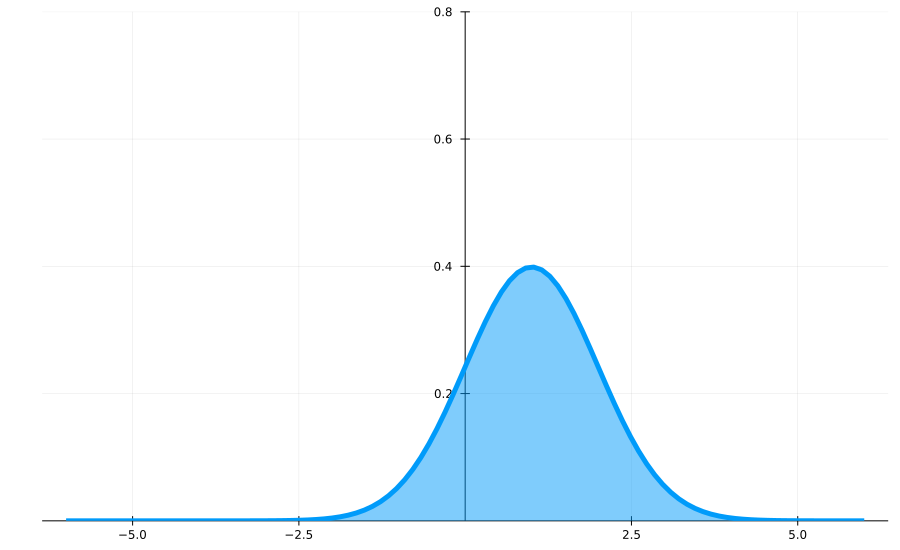

In [4]:
x = LinRange(-6,6,100)
@manipulate for μ in -1.0:0.1:1.0, σ in 0.5:0.1:1.0
    y = (1 / (σ * √(2π))) * exp.(-(1/2)*((x .- μ) / σ).^2)
    plot(x, y, framestyle=:origin, fill=0, ylim=(0.0, 0.8), fillalpha=0.5)
end

We have been using normal distributions all semester: `randn()` draws one independent sample from the _standard normal distribution_ ($\mu = 0$, $\sigma = 1$)

### Aside: how does a computer draw samples from a normal distribution?

- Assume (!) a computer has `rand()`: draws independent samples from the standard uniform distribution $U(0,1)$ (equal probability for every $x \in [0,1]$)

**[Box-Muller transform](https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform):** compute two independent samples from the standard normal distribution

1. Draw two independent samples $u_1$ and $u_2$ with `rand()`
2. Compute

$$\begin{aligned}
z_1 &\gets\sqrt{-2 \ln u_1} \cos(2\pi u_2) \\
z_2 &\gets\sqrt{-2 \ln u_1} \sin(2\pi u_2)
\end{aligned}$$

In [5]:
function box_muller(u₁, u₂)
    scale = √(-2 * log(u₁))
    p = 2π * u₂
    return (scale * cos(p), scale * sin(p))
end

box_muller (generic function with 1 method)

Plots.AnimatedGif("/home/tisaac/srv/rep/22-course-cse6643/mybinder/boxmuller.gif")
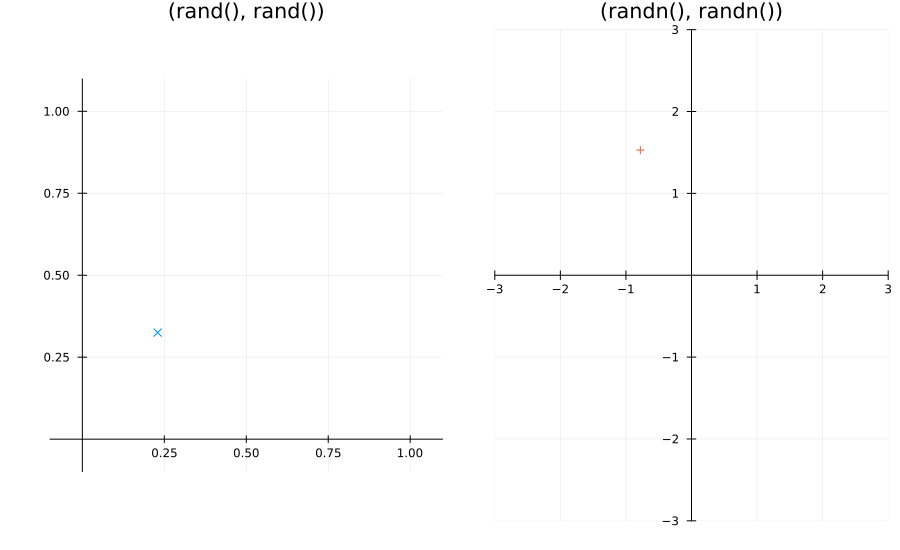

In [6]:
anim = Animation()
n_samp = 200
U = plot(lim = (-0.1, 1.1), framestyle=:origin, title="(rand(), rand())", aspect_ratio=:equal)
G = plot(lim = (-3.0, 3.0), framestyle=:origin, aspect_ration=:equal, title="(randn(), randn())")
for i in 1:n_samp
    u₁, u₂ = rand(2)
    g₁, g₂ = box_muller(u₁, u₂)
    plot!(U, [u₁], [u₂], st=:scatter, c=1, m=:x)
    plot!(G, [g₁], [g₂], st=:scatter, c=2, m=:+)
    frame(anim, plot(U, G))
end
gif(anim, "boxmuller.gif")

### How does a computer draw a sample from a $\mathcal{N}(\mu,\sigma^2)$?

By **shifting** and **scaling** (any _affine transformation_)

Assuming $z \sim \mathcal{N}(0,1)$,

$$\large \mu + \sigma z \sim \mathcal{N}(\mu, \sigma)$$

## Notice: in the Box-Muller transform, we are actually samplling a _multivariate_ normal Distribution

![](./boxmuller.gif)

A (nondegenerate) multivariate Gaussian distribution $\mathcal{N}(\mu, \Sigma)$ has a **mean** $\mu\in \mathbb{R}^m$ and a symmetric positive definite **covariance matrix** $\Sigma \in \mathbb{R}^{m\times m}$, $\Sigma = \Sigma^*$, $\Sigma \succ 0$: its probability density at vector value $x$ is

$$\large ((2\pi)^m \det \Sigma)^{-(1/2)} \exp(- \tfrac{1}{2} (x - \mu)^* \Sigma^{-1} (x - \mu))$$

The Box-Muller distribution transforms a sample from $[U(0,1)]^2$ into a sample from $\mathcal{N}(0, I_2)$.

`randn(m)` is a sample from $\mathcal{N}(0, I_m)$.

## Affine transformations of Gaussians are Gaussians

**Even changing dimensions:** if $z \sim \mathcal{N}(\mu, \Sigma)$, $\nu \in \mathbb{C}^n$ and $F \in \mathbb{C}^{n \times m}$, the

$$\large x = \nu + F z \sim \mathcal{N}(\nu + F \mu, F \Sigma F^*)$$

is Gaussian.

In particular if $z \sim \mathcal{N}(0, I)$, then

$\large x = \nu + F z \sim \mathcal{N}(\nu, F F^*).$

If $\mathrm{rank}(F) < n$, then $\mathcal{N}(\nu, FF^*)$ is a degenerate Gaussian distribution without an $n$-dimensional density ($FF^*$ is only semidefinite).

### Theorem: `randn()` is all you need to sample any multivariate Gaussian

Let $\Sigma \in \mathbb{C}^{m \times m}$ be symmetric positive semidefinite and have rank $k \leq m$.  Then there exists $F \in \mathbb{C}^{m \times k}$ such that

$$\large x \sim \mathcal{N}(\mu, \Sigma) \quad \Leftrightarrow \quad
x \sim \mu + F z, z \sim \mathcal{N}(0, I_k)$$

_Proof._

Multivariate Gaussian distributions are the building blocks of countless probabilistic / stochastic models.

In low dimensions, it is common (Occam's razor) to use relative simple multivariate distributions,

$$\large \mathcal{N}(\mu, \sigma I).$$

It is **extremely unnatural** for high dimension statistics to have covariance matrices like $\sigma I$.

### Example: an abstract data frame

Suppose I have a data frame $A$ with a large number of features $n$ and $m$ samples.

Suppose my model for the data is each row is like a random variable from $\mathcal{N}(0,I_n)$

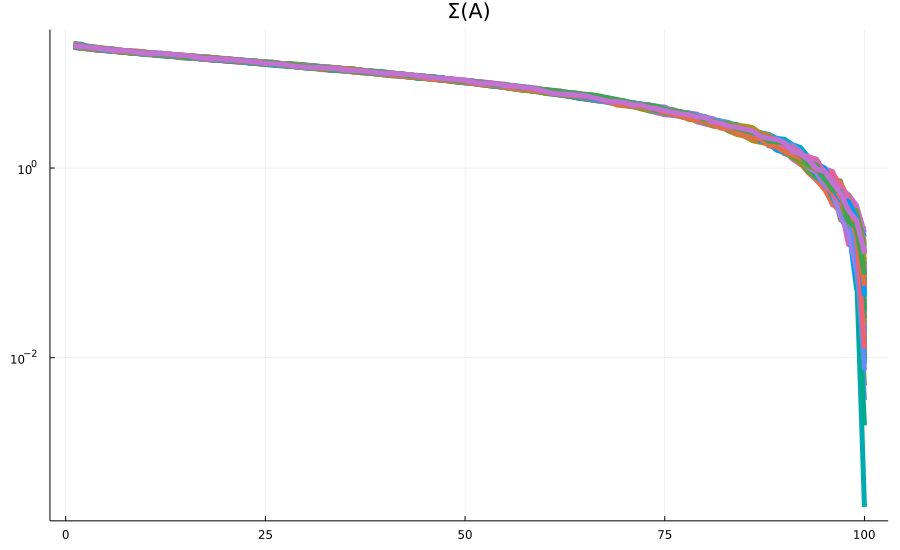

In [7]:
n = 100
m = 100
p = plot(title="Σ(A)")
for i in 1:m
    A = randn(m, n)
    plot!(p, svd(A).S, yscale=:log10)
end
p

This is **high-rank** data, and big data is **low-rank**

Takeaway: if $\Sigma$ is the covariance of a high-dimensional distribution we care about, $\Sigma$ is probably low-rank and probably has a non-trivial factorization

$\large \Sigma = F F^*.$

### Problem:  we need to draw independent samples from $\mathcal{N}(\mu, \Sigma)$ and we don't (yet) know an $F$ such that $\Sigma = FF^*$

**Example:** we are building a model of some data we have collected and have computed

$$\large \mu = \frac{1}{N} \sum_i x_i, \quad \Sigma = \frac{1}{N-1}\sum_i (x_i - \mu) (x_i - \mu)^*$$

**Solution** (assuming nondegenerate): compute $F$ as a **Cholesky factor** of $\Sigma$

### Another problem: we need to sample $\mathcal{N}(\mu, \Sigma)$ and it would be impractical to even store $F$ such that $\Sigma = F F^*$

**Example:** Gaussian process.  Each data vector $d$ is collection of values at different locations,

$$\large d_i = d(x_i).$$

The covariance between $d_i$ and $d_j$ is determined by a **kernel** based on the distance between them, such as

$$\large \Sigma_{ij} = \mathrm{cov}(d_i, d_j) = \exp(-|x_i - x_j|^2).$$

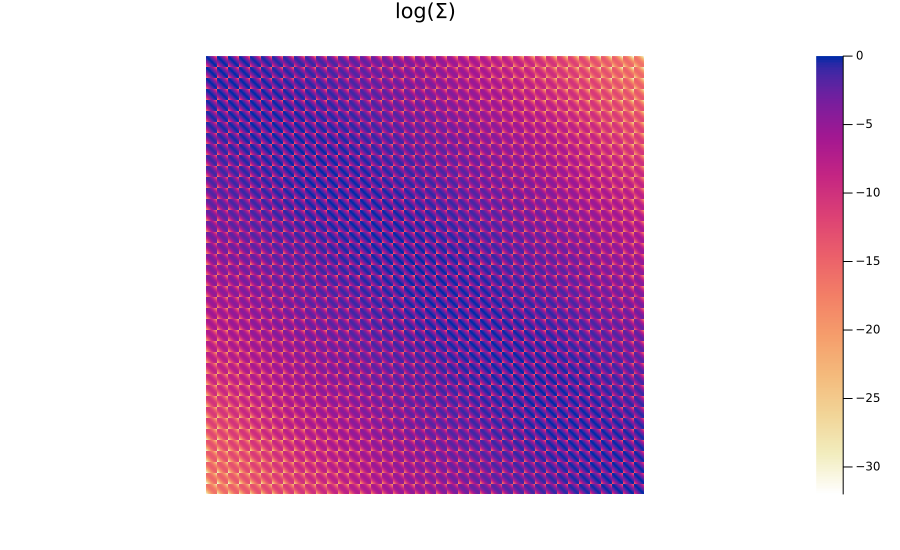

In [8]:
m = 40
x = y = LinRange(0, 1, 40)
X = [z for z in x, w in y]
X = reshape(X, length(X))
Y = [w for z in x, w in y]
Y = reshape(Y, length(Y))
XY = [X Y]
Σ = [exp(-16 * norm(XY[i,:] - XY[j,:])^2) for i in 1:size(XY)[1], j in 1:size(XY)[1]]
imshowlog(Σ, title="log(Σ)")

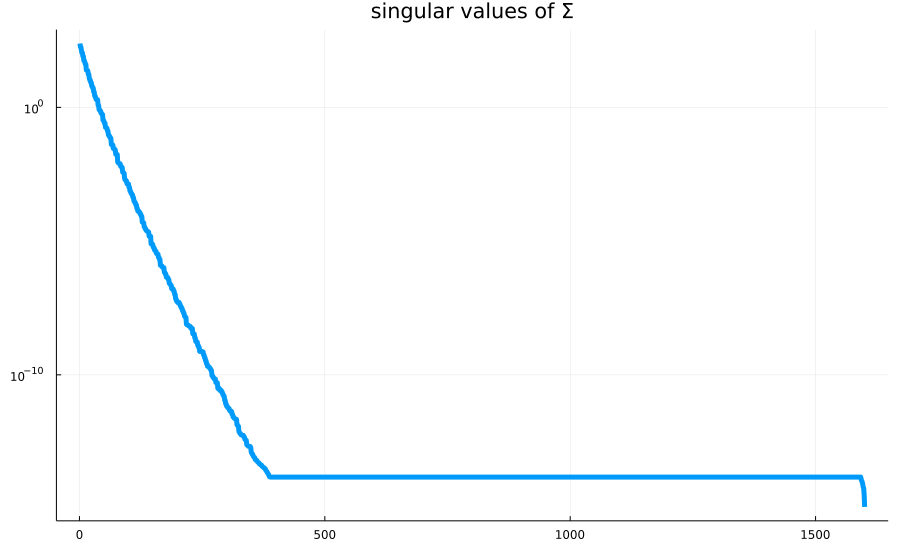

In [9]:
u,s,v = svd(Σ)
plot(s, yscale=:log10, title="singular values of Σ")

Plots.AnimatedGif("/home/tisaac/srv/rep/22-course-cse6643/mybinder/gaussianprocess.gif")
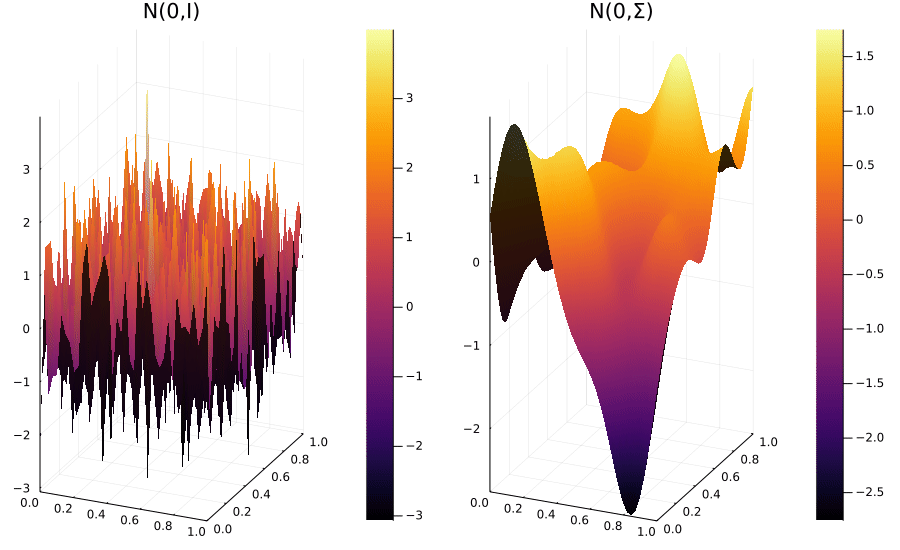

In [10]:
F = u * Diagonal(s .^ 0.5)
anim = Animation()
for i in 1:20
    ZI = randn(m, m)
    ZΣ = reshape(F *  randn(m*m), m, m)
    p = plot(x, y, ZI, st=:surf, title="N(0,I)")
    q = plot(x, y, ZΣ, st=:surf, title="N(0,Σ)")
    frame(anim, plot(p, q))
end
gif(anim, "gaussianprocess.gif", fps=1)

These **kernel-based** covariances often have **fast-methods** ($O(m \log m)$) for computing matrix vector products without storing $\Sigma$.

For these covariances, we are looking for **black-box** sampling techniques.

## Review: CG & Lanczos

$$\large x_n = \mathop{\arg\min}_{x \in \mathcal{K}_n(A,b)} \|x - A^{-1} b\|_A =
\mathop{\arg\min}_{x \in \mathcal{K}_n(A,b)} \tfrac{1}{2} x^* A x - x^* b =  
$$

$$\large \min_{x \in \mathcal{K}_n(A,b)} \|x - A^{-1} b\|_A = \min_{p_n \in P_n} \|p_n(A) e_0\|_A$$

$$\large \sim y_n = \mathop{\arg\min}_{y \in \mathbb{C}^n} \tfrac{1}{2} (Q_n y)^* A (Q_n y) - (Q_n y)^* b
= \tfrac{1}{2} y^* T_n y - y^* e_1 \|b\|_2
$$

$p_n$ is the characteristic polynomial of $T_n$ generated by the Lanczos process

Plots.AnimatedGif("/home/tisaac/srv/rep/22-course-cse6643/mybinder/lanczos.gif")
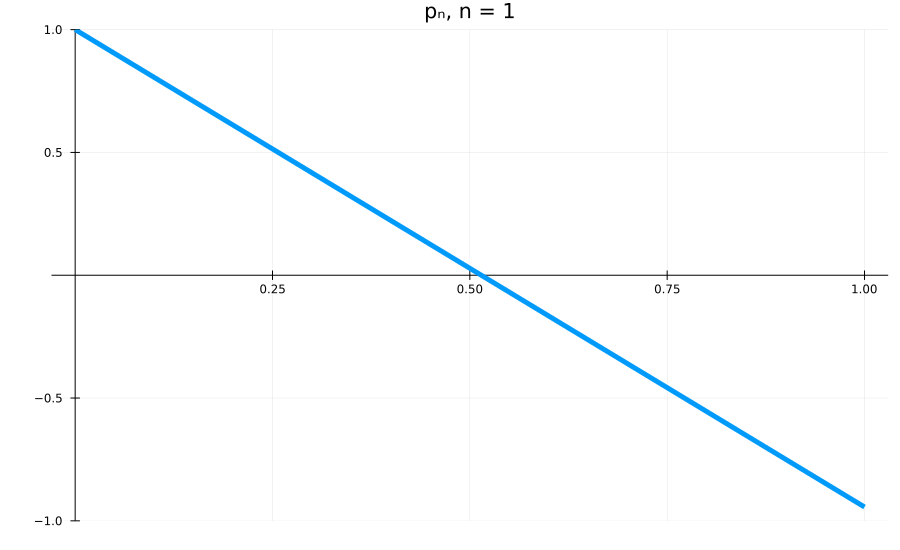

In [11]:
m = 100
Λ = LinRange(0.01, 1, m)
Q = qr(randn(m,m)).Q
A = Q * Diagonal(Λ) * Q'
H = hessenberg(A).H
T = Tridiagonal(0.5 * (H + H'))
x = LinRange(0, 1, 200)
anim = Animation()
for i in 1:20
    s = sort(eigvals(Matrix(T[1:i,1:i])))
    y = ones(length(x))
    for r in s
        y .*= (r .- x) ./ r
    end
    scale = maximum(abs.(y))
    frame(anim, plot(x, y, ylim=(-scale,scale), framestyle=:origin, title="pₙ, n = $i"))
end
gif(anim, "lanczos.gif", fps=1)

We are building $p_n \in P_n$ that is the best approximation to $f(x) = 0$ on the interval $[\lambda_{\min}, \lambda_{\max}]$

For every $p_n \in P_n$, there is a polynomial $q_{n-1}$ with degree at most $n-1$ such that

$$\large p_n(x) = 1 - x q_{n-1}(x).$$

**Q.**  If $p_n(x) \to 0$ on $[\lambda_{\min}, \lambda_{\max}]$, what does $q_{n-1}$ converge to?

$$\large 0 \approx 1 - x q_{n-1}(x) \quad \Leftrightarrow \quad q_{n-1}(x) \approx x^{-1}$$

Plots.AnimatedGif("/home/tisaac/srv/rep/22-course-cse6643/mybinder/lanczos-inv.gif")
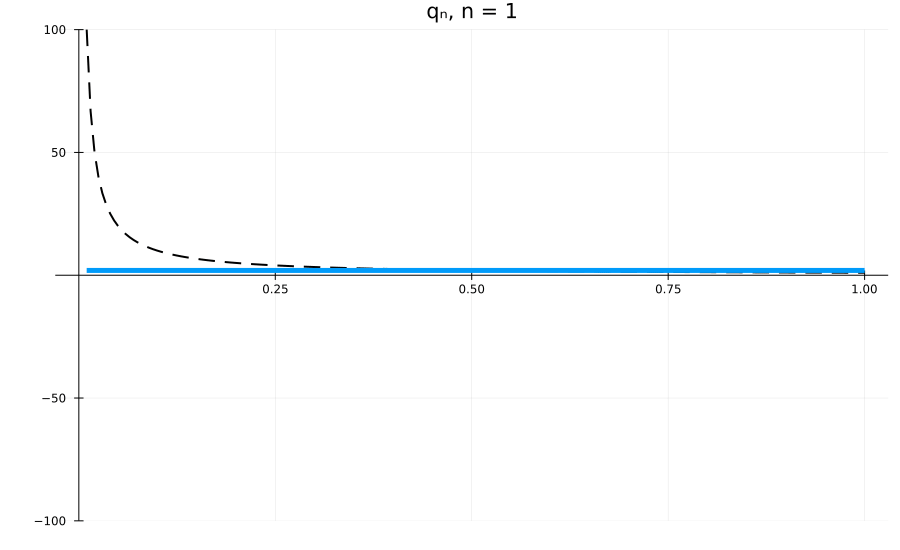

In [12]:
x = LinRange(0.01, 1, 200)
f = 1 ./ x
anim = Animation()
for i in 1:20
    s = sort(eigvals(Matrix(T[1:i,1:i])))
    y = ones(length(x))
    for r in s
        y .*= (r .- x) ./ r
    end
    scale = 100
    p = plot(x, f, title="qₙ, n = $i", c=:black, l=(2, :dash))
    frame(anim, plot!(p, x, (1 .- y) ./ x, c=1, ylim=(-scale,scale), framestyle=:origin))
end
gif(anim, "lanczos-inv.gif", fps=1)

We are trying to compute $A^{-1}  b$ and we compute $q_n(A) b$ where $q_n(x)  \approx x^{-1}$

In particular,

$$\large q_n(A)b = Q_n (T_n)^{-1} Q_n^* b$$

Given an arbitrary function $f: \mathbb{C} \to \mathbb{C}$, we can extend $f$ to diagonalizable matrices by applying it to the spectrum: if $A = X \Lambda X^{-1}$, we define

$$\large f(A) = X\ \mathrm{diag}(f(\Lambda))\ X^{-1}$$

If $f$ has a convergent polynomial series $p_n \to f$ uniformly on some open set containing $\Lambda$, then
$f(A)$ is the limit of $p_n(A)$.

### Example: matrix exponential

The solution to the linear ODE

$$\large \dot y = A y, \quad y(0) = y_0$$ is

$$\large y(t) = e^{At} y_0.$$

If we want to compute $f(A) b$ for a hermitian matrix and some arbitrary function $f$, the Lanczos iteration gives us a means to approximate it:

$$\large f(A) b \approx Q_n f(T_n) Q_n^*b$$

How quickly $Q_n f(T_n) Q_n^*b \to f(A) b$ is determined by how quickly $\sup_{\lambda \in\Lambda} |f(\lambda) - p_{T_n}(\lambda)| \to 0$

### What does all of this have to do with black-box sampling from $\mathcal{N}(0,\Sigma)$?

There is not a scalar function  $f: \mathbb{C} \to \mathbb{C}$ that approximates Cholesky factor $L$ in $A = LL^*$,

$$\large L \neq f(A).$$

But we can use _any_ $F$ such that $A = FF^*$, not just the Cholesky factor.

Every hermitian positive semidefinite matrix has a **matrix square root**: if $\Sigma = Q \Lambda Q^*$,

$$\large H = \sqrt{\Sigma} = Q \sqrt{\Lambda} Q^*.$$

$$\large H H^* = H^2 = \Sigma.$$

### The Lanczos algorithm for approximatey sampling from $\Sigma$

Compute $z \sim \mathcal{N}(0,I)$, and then at iteration $n$ of Lanczos,


$$\large x_n = Q_n T_n^{1/2} Q_n^* z$$

- Requires the computation of $T_n^{1/2}$ at each iteration: essentially the cost of one eigendecomposition of a tridiagonal matrix of size $n \ll m$

### Convergence

From (Ilić et al. 2009, _A restarted Lanczos approximation to functions of a symmetric matrix_)

$$\large \|A^{1/2} z - x_n\|_2 \leq \sqrt{\lambda_{\min}} \| r_n\|_2,$$

where $r_n$ is the residual of solving $A y = z$ by conjugate gradients.

$$\large \|r_n\|_2 = \|z - A y_n \|_2 = \|A(y - y_n)\|_2 = \| A^{1/2}(y - y_n)\|_A$$

$$\large \leq \|A^{1/2}\|_{A} \|y - y_n\|_A \leq
2 \lambda_{\max}^2 \left(\frac{\sqrt{\kappa} - 1}{\sqrt{\kappa}+1}\right)^n \underbrace{ \| y \|_A}_{\|A^{1/2} z\|_{A^{-2}}}$$

$$\large \leq 2 \kappa^2 \left(\frac{\sqrt{\kappa} - 1}{\sqrt{\kappa}+1}\right)^n \|A^{1/2} z\|_2$$

$$\Rightarrow \frac{\|A^{1/2} z - x_n\|_2}{\|A^{1/2} z\|_2} \leq 2  \sqrt{\lambda_{\min}} \kappa^2 \left(\frac{\sqrt{\kappa} - 1}{\sqrt{\kappa}+1}\right)^n$$

Although there is a coefficient out front, the convergence rate is the same as the conjugate gradient convergence rate.

Therefore the same rules apply as for CG: the smaller $\kappa$, the faster the sample converges.

## Preconditioning

Goal: modify the spectrum of $\Sigma$ so that the Lanczos approximations converge faster to a sample of $\Sigma$

We cannot just choose any $M \approx \Sigma^{-1}$ and work with $M \Sigma^{-1}$: this is not symmetric.

(We don't have "norm" preconditioning like we do with the conjugate gradient method)

We must use **symmetric preconditioning:** choose $G$ such that $GG^* \approx \Sigma^{-1}$ and
use the  Lanczos iteration to approximate

$$\large \tilde x = (G A G^*)^{1/2} z.$$

The approximation $\tilde x_n$ to $\tilde x = (G A G^*)^{1/2} z$ if we have found a good preconditioning factor $G$.

How does $\tilde x_n$ relate to what we really want to compute, $x = A^{1/2} z$?

**Trick question:** we don't really want $x = A^{1/2} z$, we want to compute a $\hat x$ from $\tilde x$ such that $\hat x\sim \mathcal{N}(0, \Sigma)$.

If we let  $\hat x = G^{-1} \tilde x = G^{-1}(G A G^*)^{1/2} z$, then

$$\large 
\mathbb{E}[\hat x \hat x^*] = G^{-1}(G A G^*)^{1/2} (G A G^*)^{1/2} G^{-*}
$$

$$\large = G^{-1} (G A G^*) G^{-*} = A$$


### Our requirements

Find $G$ such that

1. $G G^* \approx A^{-1}$
2. $G$ is fast to compute (minimize setup)
3. $G$ and $G^*$ are fast to apply
4. $G^{-1}$ is also fast to apply for post processing

Note these are more stringent conditions than we had for a preconditioner $M$ for CG (the inverse of $M$ is never needed, and it doesn't need to be in factored form).

### Which preconditioners could we use?

1. The Cholesky factor: converge in one iteration; expensive and/or infeasible

2. Incomplete Cholesky factorization: 

- $\Sigma$ of interest are _dense_: we don't have good algorithms for IC factorizations that are sparser than the original matrix.

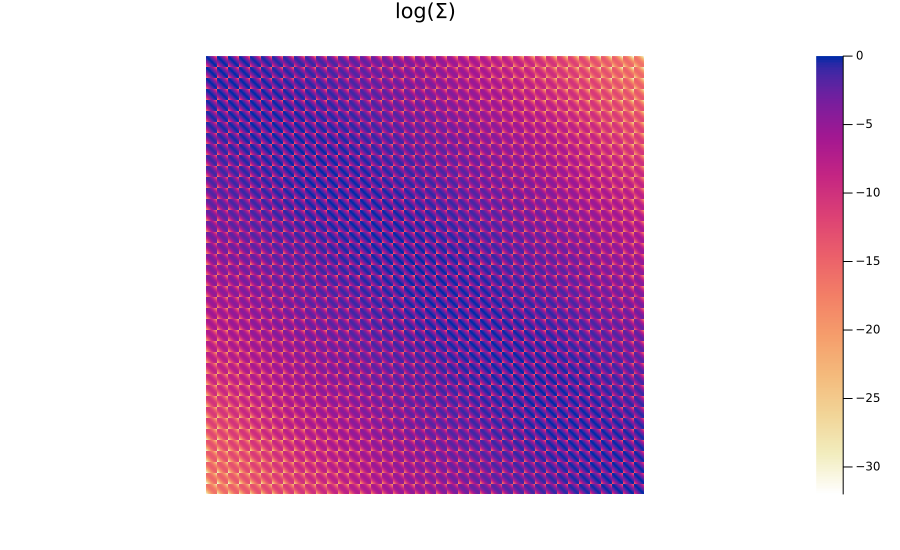

In [13]:
m = 40
x = y = LinRange(0, 1, 40)
X = [z for z in x, w in y]
X = reshape(X, length(X))
Y = [w for z in x, w in y]
Y = reshape(Y, length(Y))
XY = [X Y]
Σ = [exp(-16 * norm(XY[i,:] - XY[j,:])^2) for i in 1:size(XY)[1], j in 1:size(XY)[1]]
imshowlog(Σ, title="log(Σ)")

(To those of you doing the report: do not compare against IC preconditioning, just compare against unpreconditioned Lanczos.)

### Property of kernel matrices: essentially sparse inverses Cholesky factors

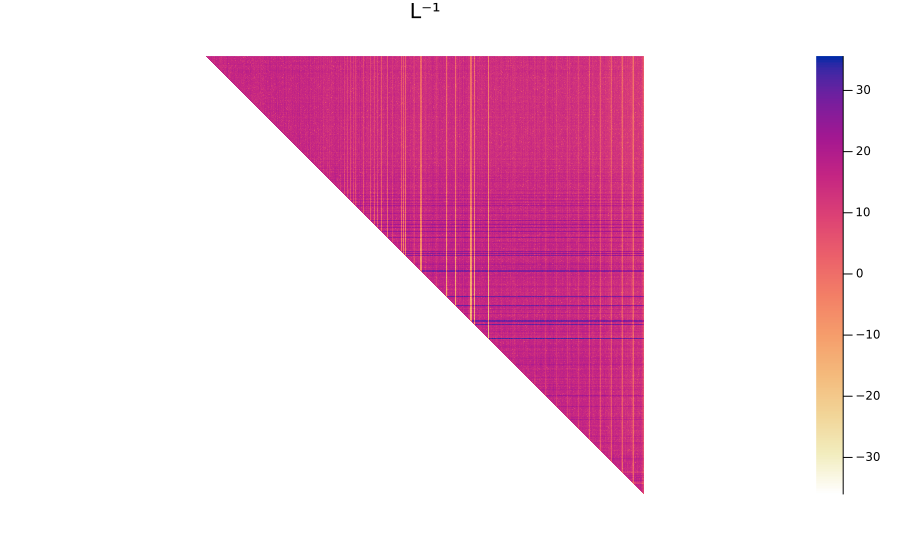

In [14]:
m = 40
x = y = LinRange(0, 1, 40)
X = [z for z in x, w in y]
X = reshape(X, length(X))
Y = [w for z in x, w in y]
Y = reshape(Y, length(Y))
XY = [X Y]
Σ = [exp(-16* norm(XY[i,:] - XY[j,:])^2) for i in 1:size(XY)[1], j in 1:size(XY)[1]]
f = factorize(Σ)
D = Diagonal(abs.(diag(f.D)).^(0.5))
G = inv(D * f.U)
imshowlog(G, title="L⁻¹")

(For a more rigorous statement: Schäfer et al. 2021, _Sparse Cholesky Factorization by Kullback-Leibler Minimization_)

### Factorized Sparse Approximate Inverse (FSAI) preconditioners

1. Choose a (lower triangular) sparsity patter $\mathcal{S}$ where we will allow $G$ to be non-zero

   - How to choose the sparsity pattern?
   
   

2. Choose $G$ to minimize over all matrices with that sparsity pattern

$$\large \| I - G L \|_F^2 = \mathrm{tr}((I - GL) (I - GL)^*)$$

$$\large = \mathrm{tr}(I - GL - L^*G^* - GAG^*)$$

(skip some calculus) $G$ is the minimizer if

$$\large (\mathrm{diag}(L)^{-1} G A)_{ij} = \delta_{ij}, \quad (i,j) \in \mathcal{S}$$

### Problem: we need $\mathrm{diag}(L)^{-1}$ to solve this optimization problem exactly

$$\large (\mathrm{diag}(L)^{-1} G A)_{ij} = \delta_{ij}, \quad (i,j) \in \mathcal{S}$$

- If $i \neq j$, then $\mathrm{diag}(L)^{-1}$ drops out,

$$\large (G A)_{ij} = 0, \quad (i,j), i\neq j \in \mathcal{S}$$

- If $i = j$, we substitute a related condition:

$$\large (G A G^*)_{ii} = 1$$